# Multi-Label Classification Model From Scratch: Step-by-Step Tutorial

This tutorial will guide you through each step of creating an efficient ML model for multi-label text classification. We will use DeBERTa as a base model, which is currently the best choice for encoder models, and fine-tune it on our dataset. This dataset contains 3140 meticulously validated training examples of significant business events in the biotech industry. Although a specific topic, the dataset is universal and extremely beneficial for various business data classification tasks. Our team open-sourced the dataset, aiming to transcend the limitations of existing benchmarks, which are more academic than practical. By the end of this tutorial, you will get an actionable model that surpasses most of the popular solutions in this field.

> Credit: https://huggingface.co/blog/Valerii-Knowledgator/multi-label-classification  
> Maintaining by TA.Pooh, 10-09-2025

## Requirements:

Before starting the project, please make sure that you have installed the following packages:

In [13]:
%%capture
!pip install datasets==3.6.0 transformers evaluate sentencepiece accelerate

In [14]:
# Suppress UserWarnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Download Datasets

In [15]:
from datasets import load_dataset

dataset = load_dataset(
    'knowledgator/events_classification_biotech',
    trust_remote_code=True
)

classes = [class_ for class_ in dataset['train'].features['label 1'].names if class_]
class2id = {class_:id for id, class_ in enumerate(classes)}
id2class = {id:class_ for class_, id in class2id.items()}

README.md: 0.00B [00:00, ?B/s]

events_classification_biotech.py: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

The dataset encompasses 31 classes, including a 'None' category, to cover various events and information types such as event organisation, executive statements, regulatory approvals, hiring announcements, and more.

In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'content', 'target organization', 'all_labels', 'all_labels_concat', 'label 1', 'label 2', 'label 3', 'label 4', 'label 5'],
        num_rows: 2759
    })
    test: Dataset({
        features: ['title', 'content', 'target organization', 'all_labels', 'all_labels_concat', 'label 1', 'label 2', 'label 3', 'label 4', 'label 5'],
        num_rows: 381
    })
})

Sample:

In [17]:
from pprint import pprint

# Show the first example from the train split
pprint(dataset['train'][0])

{'all_labels': ['other'],
 'all_labels_concat': 'other',
 'content': 'Drive Your Plow Over the Bones of The Dead\n'
            'by Olga Tokarczuk. I am an incredibly slow reader, but the tone '
            'and specificity of the world she creates in this book was '
            'something I couldnt leave behind until it was done. Also: All We '
            'Sawby Anne Michaels, Fight Nightby Miriam Toews, and The Summer '
            'Before the Darkby Doris Lessing.\n'
            'Id like turned into a Netflix show:\n'
            'by Amia Srinivasan. One of the most brain-shattering books Ive '
            'ever read. Her thinking is so electrically rigorous and fearless. '
            '(I double DARE them to make this into a Netflix show!)\n'
            '...I last bought:\n'
            '. I rediscovered her poetry lately, and I feel like I dont want '
            'to read anything else for a while. She owns desire and submerged '
            'things.\n'
            '...has the g

### Visualization

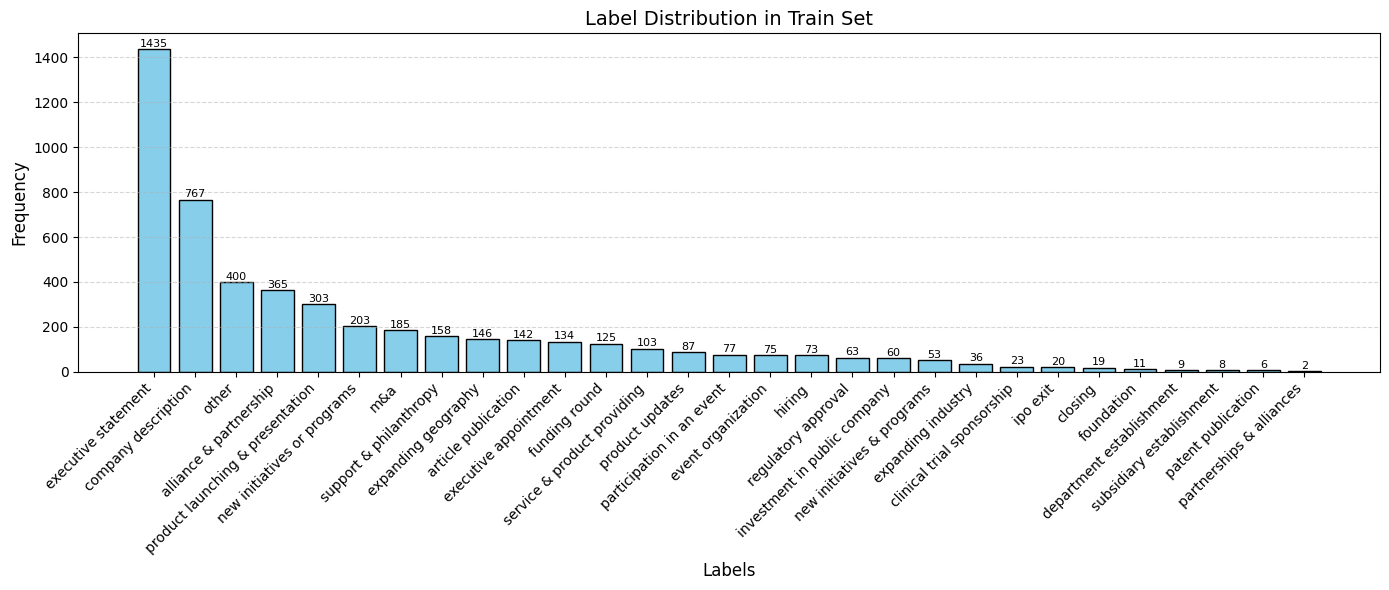

In [18]:
import matplotlib.pyplot as plt
from collections import Counter

# Flatten all label lists into a single list
all_label_lists = dataset['train']['all_labels']
flat_labels = [label for label_list in all_label_lists for label in label_list]

# Count label frequencies
label_counts = Counter(flat_labels)
sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)

# Unpack
labels, counts = zip(*sorted_labels)

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(labels, counts, color='skyblue', edgecolor='black')

# Add value labels on top of bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, str(count),
             ha='center', va='bottom', fontsize=8)

plt.xlabel('Labels', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Label Distribution in Train Set', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Labels:

In [19]:
id2class

{0: 'event organization',
 1: 'executive statement',
 2: 'regulatory approval',
 3: 'hiring',
 4: 'foundation',
 5: 'closing',
 6: 'partnerships & alliances',
 7: 'expanding industry',
 8: 'new initiatives or programs',
 9: 'm&a',
 10: 'service & product providing',
 11: 'new initiatives & programs',
 12: 'subsidiary establishment',
 13: 'product launching & presentation',
 14: 'product updates',
 15: 'executive appointment',
 16: 'alliance & partnership',
 17: 'ipo exit',
 18: 'article publication',
 19: 'clinical trial sponsorship',
 20: 'company description',
 21: 'investment in public company',
 22: 'other',
 23: 'expanding geography',
 24: 'participation in an event',
 25: 'support & philanthropy',
 26: 'department establishment',
 27: 'funding round',
 28: 'patent publication'}

## Tokenizer

After that, we tokenise the dataset and process labels for multi-label classification. Firstly, we gonna initialise the tokeniser. In our tutorial, we will use DeBERTa model,
for encoder-base models.

In [20]:
from transformers import AutoTokenizer

model_path = 'microsoft/deberta-v3-small'

tokenizer = AutoTokenizer.from_pretrained(model_path)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Then, we tokenize the dataset and process labels for multi-label classification

In [21]:
def preprocess_function(example):
    text = f"{example['title']}.\n{example['content']}"
    all_labels_tmp = example['all_labels']

    # Handle all labels data
    if isinstance(all_labels_tmp, str):
        all_labels = all_labels_tmp.split(', ')
    else:
        all_labels = all_labels_tmp

    # One-Hot Encoding Labels
    labels = [0. for i in range(len(classes))]

    for label in all_labels:
        label_id = class2id[label]
        labels[label_id] = 1.

    # Tokenized Title and Content
    example = tokenizer(text, truncation=True)
    example['labels'] = labels
    return example

tokenized_dataset = dataset.map(preprocess_function)

Map:   0%|          | 0/2759 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/381 [00:00<?, ? examples/s]

After that, we initialize the DataCollatorWithPadding. It's more efficient to dynamically pad the sentences to the longest length in a batch during collation instead of padding the whole dataset to the maximum length.

In [22]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Metrics

Implementing metrics during training is super helpful for monitoring model performance over time. It can help avoid over-fitting and build a more general model.

In [23]:
import evaluate
import numpy as np

# Combine metrics with averaging methods for multilabel
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

# Set threshold at 0.5
THRESHOLD = 0.5

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Apply sigmoid to raw logits
    probs = sigmoid(predictions)

    # Apply Threshold
    y_pred = (probs > THRESHOLD).astype(int).reshape(-1)
    y_true = labels.astype(int).reshape(-1)

    return clf_metrics.compute(predictions=y_pred, references=y_true)

## Model

Let's initialise our model and pass all necessary details about our classification task, such as the number of labels, class names and their IDs, and type of classification.

In [24]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=len(classes),
    id2label=id2class,
    label2id=class2id,
    problem_type="multi_label_classification"
)

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training Steps

Next, we must configure the training arguments, and then we can begin the training process.

In [25]:
# Monitor via wandb
report_to = "wandb"

In [26]:
# Optional, run this cell if you don't want to report to wandb
import os
os.environ["WANDB_DISABLED"] = "true"
report_to = None

In [27]:
training_args = TrainingArguments(
    output_dir="my_multi_label_classify_model",
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to=report_to
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [28]:
%%time
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.160400,0.151654,0.949860,0.416842,0.673469,0.301829


CPU times: user 7min 25s, sys: 4.93 s, total: 7min 29s
Wall time: 7min 51s


TrainOutput(global_step=2759, training_loss=0.18277206780384225, metrics={'train_runtime': 470.5332, 'train_samples_per_second': 5.864, 'train_steps_per_second': 5.864, 'total_flos': 446686886740836.0, 'train_loss': 0.18277206780384225, 'epoch': 1.0})

### Saves model and tokenizer config

In [29]:
trainer.save_model("my_multi_label_classify_model")

### Evaluation

In [42]:
import torch

# Get predictions on test set
preds_output = trainer.predict(tokenized_dataset['test'])

# Apply sigmoid to logits
probs = torch.sigmoid(torch.tensor(preds_output.predictions)).numpy()

# Apply threshold
y_pred = (probs > THRESHOLD).astype(int)

# Get ground truth labels
y_true = preds_output.label_ids.astype(int)

In [44]:
from sklearn.metrics import classification_report

# Avoid warnings if some classes aren't predicted
report = classification_report(
    y_true,
    y_pred,
    target_names=classes,
    zero_division=0
)
print(report)

                                  precision    recall  f1-score   support

              event organization       0.00      0.00      0.00         9
             executive statement       0.68      0.87      0.76       162
             regulatory approval       0.00      0.00      0.00         8
                          hiring       0.00      0.00      0.00        12
                      foundation       0.00      0.00      0.00         2
                         closing       0.00      0.00      0.00         4
        partnerships & alliances       0.00      0.00      0.00         0
              expanding industry       0.00      0.00      0.00         4
     new initiatives or programs       0.00      0.00      0.00        28
                             m&a       0.00      0.00      0.00        19
     service & product providing       0.00      0.00      0.00         8
      new initiatives & programs       0.00      0.00      0.00         6
        subsidiary establishment     

## Inference

In [30]:
title = dataset['test'][0]['title']
title

'Renton investor purchases Vivacity Care building'

In [31]:
content = dataset['test'][0]['content']
content

"SMS\nA Renton, Washington-based investor has purchased a building occupied by Vivacity Care Center in Spokane Valley.\nSpokane Valley Clinic LLC, whose principal is Soyam Vahora, CEO of Renton-based Aamir Stations, bought the building for $7.7 million earlier this month from Spokane investor John Pariseau, according to Spokane County Assessors Office records.\nPremera Blue Cross and Vera Whole Health opened the 12,000-square-foot Vivacity Care Center, at 16009 E. Indiana Ave., last year, marking the third location in the Spokane area.\nThe center is part of Premeras plan to expand advanced primary care services in Spokane. Premera and Vera Whole Health opened the first Vivacity Care Center at 9001 N. Country Homes Blvd. in January 2020.\nClayton J. Brown, Christopher Edwards and Ruthanne Romero, investment specialists in commercial real estate brokerage Marcus & Millichaps Seattle office, represented the seller.\nVahora was not immediately available for comment on the purchase.\nPreme

In [32]:
# Load the Trained Model
loaded_model = AutoModelForSequenceClassification.from_pretrained(
    "my_multi_label_classify_model"
)

# Prepare the Text Input for Inference
text = f"{title}\n{content}"

# Tokenize your input
inputs = tokenizer(text, return_tensors="pt", truncation=True)

# Run the Model and Apply Sigmoid + Threshold
loaded_model.eval()

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-5): 6 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [33]:
with torch.no_grad():
    outputs = loaded_model(**inputs)
    logits = outputs.logits

    # get probabilities
    probs = torch.sigmoid(logits).numpy()[0]

# Apply the threshold
predictions = (probs > THRESHOLD).astype(int)

# Convert Predicted Vector Back to Labels
predicted_labels = [id2class[i] for i, pred in enumerate(predictions) if pred == 1]
print(predicted_labels)

['executive statement']


In [34]:
# Display Raw Probabilities & Predictions
print(f"Threshold:\n{THRESHOLD}\n")
print(f"Probabilities:\n{probs}\n")
print(f"Predictions:\n{predictions}")

Threshold:
0.5

Probabilities:
[0.02499081 0.8178728  0.03909446 0.02497892 0.00983953 0.01196677
 0.00496508 0.0139916  0.082129   0.15247598 0.05959196 0.02826313
 0.01164561 0.0960694  0.03575831 0.0924705  0.2542856  0.01084875
 0.02614232 0.01078263 0.38421023 0.01863883 0.03721768 0.07774134
 0.02582966 0.04462525 0.00941765 0.09387078 0.00588158]

Predictions:
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


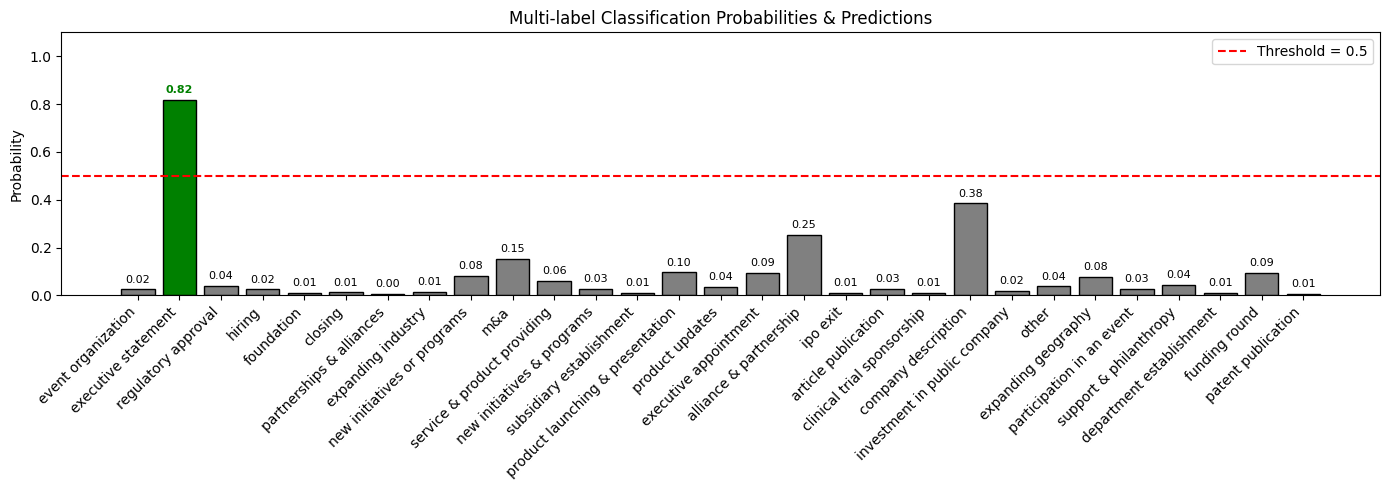

In [35]:
# Colors: highlight predictions
colors = ['green' if pred == 1 else 'gray' for pred in predictions]

# Plot
plt.figure(figsize=(14, 5))
bars = plt.bar(classes, probs, color=colors, edgecolor='black')

# Threshold line
plt.axhline(y=THRESHOLD, color='red', linestyle='--', label=f"Threshold = {THRESHOLD}")

# Annotate predicted labels
for i, (bar, prob, pred) in enumerate(zip(bars, probs, predictions)):
    label = f"{prob:.2f}"
    if pred == 1:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, label,
                 ha='center', va='bottom', fontsize=8, fontweight='bold', color='green')
    else:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, label,
                 ha='center', va='bottom', fontsize=8, color='black')

plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.1)
plt.ylabel("Probability")
plt.title("Multi-label Classification Probabilities & Predictions")
plt.legend()
plt.tight_layout()
plt.show()

If you've carefully followed each step of this guide, you now possess a highly effective tool. The training procedure is straightforward and yields remarkable results. We built it using exclusively open-source solutions and achieved excellent outcomes.

## Multilingual Model

If you are interested in a multilingual version of the model, please use mDeBERTa-v3 (multilingual DeBERTa V3) which supports over 100 languages. Check it out here:
https://huggingface.co/microsoft/mdeberta-v3-base